In [10]:
from IPython.display import Image
Image(url="/content/1.png")

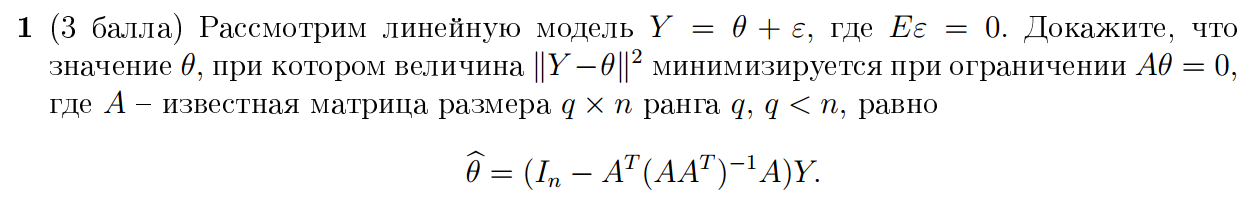

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$
$\newcommand{\lr}[1]{\left(#1\right)}$

Решается задача
$$\min_{s.t.\ A\theta = 0}\norm{Y - \theta}^2$$

То есть ищется проекция $Pr_{A^\bot}Y$

Не стану переписывать доказательство [Формулы (p.430)](https://personal.utdallas.edu/~jwz120030/Teaching/M4355/Books/MeyerMatrixAnalysis.pdf)

Матрица $A^\mathsf{T}$ задаёт подпространство $\mathbb{R}^n$ с базисом из $q$ векторов
$$Pr_{A^\mathsf{T}}Y = A^\mathsf{T}\lr{AA^\mathsf{T}}^{-1}A$$
$$Pr_{A^\mathsf{T}} = I - Pr_{A^\bot}$$
Итого, $$\hat{\theta} = Pr_{A^\bot}Y = \lr{I - A^\mathsf{T}\lr{AA^\mathsf{T}}^{-1}A}Y$$